In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import odespy

In [3]:
import odespy

In [4]:
from scipy.interpolate import interp1d

# VHM model implementation

### EE wise

In [1]:
umax = 300.0
uevap = 150.0

c1s = 1.8
c2s = 0.6
c3s = 1.0

c1o = -3.5
c2o = 2.0
c3o = 0.0
c4o = -0.0

c1i = -3.2
c2i = 2.24
c3i = 0.0
c4i = 0.0

nso = 1

Kg = 2400.0
Ki =120.0
Ko =10.0

#Define the constants
area = 361.0

#Define the initial conditions
u = 170.0
qg =1.0
cg =0.0
qo =0.0
co =0.0
qi =1.0
ci =0.0

DATA

In [2]:
# read data
data = pd.read_csv("/media/DATA/Githubs/doctoraat/code_writing/data/nete/data_brach_case_nete.csv", parse_dates=True, 
                  index_col=0)

In [3]:
raindata = data['2003']['rain']
petdata = data['2003']['evapotranspiration']

### Test EE

In [4]:
from numpy import float64

In [5]:
def VHM(Pars,Const,InitCond,Rain,ET, linear=True):

    #Define the parameters
    ##################################
    #Storage model parameters
    umax = float64(Pars[0])      #Maximum storage for soil moiture sompartiment
    uevap = float64(Pars[1])
    c1s = float64(Pars[2])
    c2s = float64(Pars[3])
    c3s = float64(Pars[4])
    #OF model parameters
    c1o = float64(Pars[5])
    c2o = float64(Pars[6])
    c3o = float64(Pars[7])      #eventueel aanpassen, zodat enkel c1 of c3 in te geven, vermits zelfde parameter...
    c4o = float64(Pars[8])
    #IF model parameters
    c1i = float64(Pars[9])
    c2i = float64(Pars[10])
    c3i = float64(Pars[11])      #eventueel aanpassen, zodat enkel c1 of c3 in te geven, vermits zelfde parameter...
    c4i = float64(Pars[12])
    ns = Pars[13]       #antecedent day = # voorgaande dagen waarvan bui no in rekening gebracht
    #Flow Routin parameter
    Kg = float64(Pars[14])
    Ki = float64(Pars[15])
    Ko = float64(Pars[16])

    #Define the constants
    ##################################
    area = float64(Const[0])     #catchment area
    totn = Rain.size     #Timesteps (eigenlijk niet nodig als gepast inputs!)

    #Define the initial conditions
    ##################################
    u = float64(InitCond[0])     #Soil moisture storage
    qg = float64(InitCond[1])    #baseflow
    cg = float64(InitCond[2])   #baseflow current timestep
    qo = float64(InitCond[3])    #overland flow
    co = float64(InitCond[4])    #overland flow current timestep
    qi = float64(InitCond[5])    #interflow
    ci = float64(InitCond[6])    #interflow current timestep

    qr = qo + qi + qg
    v = float64(area * 1000.0 / (60.0 * 60.0))    #mm to m3/s

    #Define arrays for outputs
    ##################################
    t_out=np.zeros(totn)

    q_out=np.zeros(totn,float64)
    qo_out=np.zeros(totn,float64)
    qi_out=np.zeros(totn,float64)
    qg_out=np.zeros(totn,float64)

    u_out=np.zeros(totn,float64)

    fe_out=np.zeros(totn,float64)
    fu_out=np.zeros(totn,float64)
    fs_out=np.zeros(totn,float64)
    fi_out=np.zeros(totn,float64)

    s_out=np.zeros(totn,float64)
    aet_out=np.zeros(totn,float64)

    fs1_out=np.zeros(totn,float64)
    fs2_out=np.zeros(totn,float64)
    fi1_out=np.zeros(totn,float64)
    fi2_out=np.zeros(totn,float64)

    #Define array for moving window -antecedent rainfall
    sb=np.zeros(ns+2)  #grootte nog te checken

    #Start dynamic run
    for t in range(totn):
        neersl = float64(Rain[t])
        evap = float64(ET[t])

        #Soil Moisturs storage submodel
        if linear == True:                     #for relation between soil moisture storage and fraction interflow/overland
            fu = c1s - c2s*u/umax
        else:
            fu = c1s - np.exp(c2s*(u/umax)**c3s)  #corrct?!?hetgeen in exp zit (c2*u/umax**c3 moet dus eigenlijk negatief zijn...

        #FractionSUM=1 corrector
        if fu>1.0:
            fu=float64(1.0)

        #Evapotranspiration submodel  (ANDERS IN VISUAL BASIC?!?)
        if u > uevap:
            fe = evap
        else:
            fe = evap*u/(uevap)   #lineair

        #Soil moisture balance
        u = u + fu*neersl - fe   #Soil storage + neerslag - evapotranspiratie

        #ANTECEDENT Rainfall to represent soil surface wetness
        sb[ns + 1] = neersl
        s = float64(0.0)
        for ts in range(2,ns + 2):
            sb[ts-1] = sb[ts]
            s = s + sb[ts-1] / (ns*1.0)
        cov = co
        civ = ci
        cgv = cg


#########KANS 1 EN 2##################################
##        #Fractions overland - pre
##        fs1 = np.exp(c1o + c2o*u/umax)      #c1o en c3o zijn te combineren tot 1 parameter!
##        if s > 0.0:
##            fs2 = c3o + c4o * np.log(s)
##        else:
##            fs2 = 0.0
##
##        #fracties interflow - pre
##        fi1 = np.exp(c1i + c2i*u/umax)      #c1i en c3i zijn te combineren tot 1 parameter!
##        if s > 0.0:
##            fi2 = c3i + c4i * np.log(s)
##        else:
##            fi2 = 0.0
##
####        ##KANS1##
####        if s > 0:
####            fs = np.exp(np.log(fs1) + fs2)
####        else:
####            fs = 0
####
####        if s > 0:
####            fi = np.exp(np.log(fi1) + fi2)
####        else:
####            fi = 0
##
####        ##KANS2##
##        fs = np.exp(np.log(fs1) + fs2)     #Fractions overland
##        fi = np.exp(np.log(fi1) + fi2)     #Fractions interflow
###################################################

##########KANS3####################################
        #Fractions overland - pre
        fs1 = np.exp(c1o + c2o*u/umax)      #c1o en c3o zijn te combineren tot 1 parameter!
        if s > 0.0:
            fs2 = np.exp(c3o + c4o * np.log(s))
        else:
            fs2 = float64(0.0)

        #fracties interflow - pre
        fi1 = np.exp(c1i + c2i*u/umax)      #c1i en c3i zijn te combineren tot 1 parameter!
        if s > 0.0:
            fi2 = np.exp(c3i + c4i * np.log(s))
        else:
            fi2 = float64(0.0)

        fs = fs1*fs2     #Fractions overland

        #FractionSUM=1 corrector
        if fu+fs > 1.0:
            fs=float64(1.0)-fu

        fi = fi1*fi2     #Fractions interflow

        #FractionSUM=1 corrector
        if fu+fs+fi > 1.0:
            fi=float64(1.0)-fu-fs

        co = fs * neersl                    #overland flow
        ci = fi * neersl                    #interflow
        cg = neersl - co - ci - fu * neersl #rest for slow flow routing

##        if cg < 0:          #Corrigeren voor negatieve cg waarden
##            #print 'Problem with balance! negative baseflow'
##            cg = float64(0.0)
#########################################


        #if neersl> 0.0:               #checken of som van de deelstromen 1.0 is...
        #    print fs+fi+fu+cg/neersl

        #Routing
        #Linear reservoir for the  3 routing types
        qo = qo * np.exp(-1/Ko) + 0.5 * (co + cov) * (1 - np.exp(-1/Ko)) * v  #omzetten nr m3/s voor "nieuwe" deel
        qi = qi * np.exp(-1/Ki) + 0.5 * (ci + civ) * (1 - np.exp(-1/Ki)) * v
        qg = qg * np.exp(-1/Kg) + 0.5 * (cg + cgv) * (1 - np.exp(-1/Kg)) * v
        q = qo + qi + qg
        #print q

        #Outputs
        t_out[t] = t+1
        q_out[t] = q
        qo_out[t] = qo
        qi_out[t] = qi
        qg_out[t] = qg
        u_out[t] = u
        fu_out[t] = fu
        fe_out[t] = fe
        fs_out[t] = fs
        fi_out[t] = fi
        s_out[t] = s
        aet_out[t] = fe
        fs1_out[t] = fs1
        fs2_out[t] = fs2
        fi1_out[t] = fi1
        fi2_out[t] = fi2

    return [t_out,q_out,qo_out,qi_out,qg_out,u_out,fu_out,fe_out,fs_out,fi_out,s_out,aet_out,fs1_out,fs2_out,fi1_out,fi2_out]

In [10]:
pars=[umax,uevap,c1s,c2s,c3s,c1o,c2o,c3o,c4o,c1i,c2i,c3i,c4i,nso,Kg,Ki,Ko]
const=[area]
init_cond = [u,qg,cg,qo,co,qi,ci]
trg = VHM(pars, const, init_cond, raindata, petdata, linear=False)

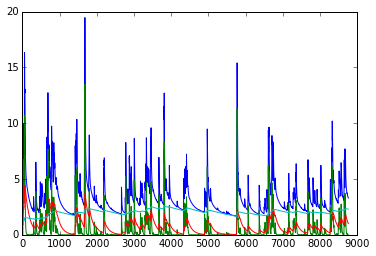

In [11]:
plt.figure()
plt.plot(trg[0],trg[1],label='Total flow')
plt.plot(trg[0],trg[2],label='Overland flow')
plt.plot(trg[0],trg[3],label='Interflow')
plt.plot(trg[0],trg[4],label='Baseflow')

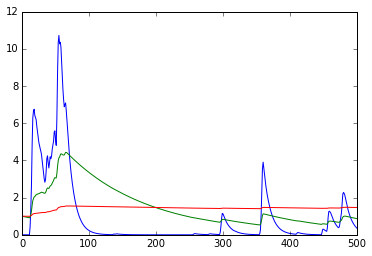

In [21]:
plt.figure()
plt.plot(trg[0][:500],trg[2][:500],label='soil moisture')
plt.plot(trg[0][:500],trg[3][:500],label='soil moisture')
plt.plot(trg[0][:500],trg[4][:500],label='soil moisture')

### Test other solvers

In [13]:
def deriv(u, t):
    rain = rain_int(t)
    pet = pet_int(t)
    
    fu = c1s - np.exp(c2s*(u[0]/umax)**c3s)
    ea = pet*u[0]/(uevap)
    
    fs1 = min(1., np.exp(c1o + c2o*u[0]/umax))
    fi1 = min(1., np.exp(c1i + c2i*u[0]/umax))
    fg1 = 1. - fs1 - fi1 - fu
    
    uf = fu*rain - ea
    of = fs1*rain - Ko * u[1]
    inf = fi1*rain - Ki * u[2]
    sf = fg1*rain - Kg * u[3]
    return [uf, of, inf, sf]

In [14]:
totaltime = raindata[:500].values.size  # simtime and steps
time_points = np.linspace(0.0, totaltime-1, totaltime)

rain_int = interp1d(time_points, raindata[:500].values, kind='nearest', bounds_error=False, fill_value=0.0)
pet_int = interp1d(time_points, petdata[:500].values, kind='nearest', bounds_error=False, fill_value=0.0)

init_cond = [u, 0.0, 0.0, 0.0]

Solve the model

In [16]:
solver = odespy.Dopri5(deriv)
solver.set_initial_condition(init_cond)
u, t = solver.solve(time_points)

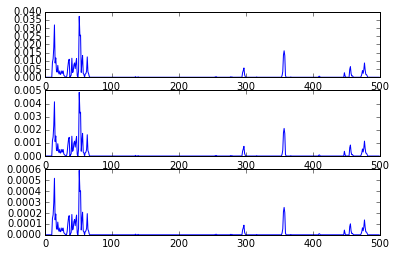

In [24]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(t, u[:,1])
axs[1].plot(t, u[:,2])
axs[2].plot(t, u[:,3])

In [18]:
odespy.list_all_solvers()

['AdamsBashMoulton2',
 'AdamsBashMoulton3',
 'AdamsBashforth2',
 'AdamsBashforth3',
 'AdamsBashforth4',
 'Backward2Step',
 'BackwardEuler',
 'BogackiShampine',
 'CashKarp',
 'CrankNicolson',
 'Dop853',
 'Dopri5',
 'DormandPrince',
 'Euler',
 'EulerCromer',
 'Fehlberg',
 'ForwardEuler',
 'Heun',
 'Leapfrog',
 'LeapfrogFiltered',
 'Lsoda',
 'Lsodar',
 'Lsode',
 'Lsodes',
 'Lsodi',
 'Lsodis',
 'Lsoibt',
 'MidpointImplicit',
 'MidpointIter',
 'RK2',
 'RK3',
 'RK34',
 'RK4',
 'RKC',
 'RKF45',
 'RKFehlberg',
 'Radau5',
 'Radau5Explicit',
 'Radau5Implicit',
 'RungeKutta1',
 'RungeKutta2',
 'RungeKutta3',
 'RungeKutta4',
 'ThetaRule',
 'Trapezoidal',
 'Vode',
 'lsoda_scipy',
 'odefun_sympy',
 'odelab']